In [18]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import load_logging_data
from utils.assemble_model import build_predict_model
from utils.layer import FeatureWiseScalingLayer
from utils.model import DecompositionLayer
from utils.miscellaneous import create_seq_dataset_multiple_input_single_output
from tensorflow import keras
from tqdm.notebook import tqdm

In [2]:
train_data = load_logging_data(data_root_path='data/train')
val_data = load_logging_data(data_root_path='data/val')

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_data['Data_Type'] = 'train'
val_data['Data_Type'] = 'validation'

dataset = pd.concat([train_data, val_data], axis=0)
dataset.reset_index(drop=True, inplace=True)

In [4]:
dataset

,Time 1 - default sample rate,BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 2 CH=151,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation


In [5]:
angle_name_list = list(dataset.columns)[22:24] + list(dataset.columns)[26:28]
print(angle_name_list)

pressure_name_list = list(dataset.columns)[18:20] + list(dataset.columns)[24:26]
print(pressure_name_list)

new_angle_name_list = ['Mast_X(deg)', 'Mast_Y(deg)', 'Base_X(deg)', 'Base_Y(deg)']
new_pressure_name_list = ['P1(bar)', 'P2(bar)', 'P3(bar)', 'P4(bar)']

dataset.rename(columns={'Time  1 - default sample rate': 'Time(sec)'}, inplace=True)
dataset.rename(columns={'caloutput_drill_depth CH=26': 'Drill_Depth(m)'}, inplace=True)
dataset.rename(columns={'caloutput_rotate_velocity CH=25': 'Drill_Rotation(RPM)'}, inplace=True)

for angle_name, new_angle_name in zip(angle_name_list, new_angle_name_list):
    dataset.rename(columns={angle_name: new_angle_name}, inplace=True)

for pressure_name, new_pressure_name in zip(pressure_name_list, new_pressure_name_list):
    dataset.rename(columns={pressure_name: new_pressure_name}, inplace=True)

# dataset['Work_Load'] = (dataset[new_pressure_name_list[0]] * (dataset['Drill_Rotation(RPM)']))
dataset['Drill_Depth(m)'] = dataset['Drill_Depth(m)']/10

dataset

['angle_Mast_X CH=27', 'angle_Mast_Y CH=28', 'angle_base_X CH=31', 'angle_base_Y CH=32']
['pressure_1_pressure_transmitter_1_drive1 CH=23', 'pressure_1_pressure_transmitter_2_drive2 CH=24', 'pressure_2_pressure_transmitter_6_cyl_1 CH=29', 'pressure_3_pressure_transmitter_7_cyl_2 CH=30']


,Time(sec),BUMA 1_1 CH=4,BUMA 1_2 CH=5,BUMA 1_3 CH=6,BUMA 2_1 CH=7,BUMA 2_2 CH=8,BUMA 2_3 CH=9,BUMA 3_1 CH=10,BUMA 3_2 CH=11,BUMA 3_3 CH=12,...,MX840B_CH 2 CH=151,MX840B_CH 3 CH=152,MX840B_CH 4 CH=153,MX840B_CH 5 CH=154,MX840B_CH 6 CH=155,MX840B_CH 7 CH=156,MX840B_CH 8 CH=157\n,Work_Mode,Diff_Time(sec),Data_Type
0,0.000000,-3.678,-4.9400,-3.767,-1.9070,-0.08352,0.04852,-1.8750,-0.7639,-0.49290,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.0,train
1,0.100000,-2.509,-3.6970,-2.093,-0.9704,0.48000,1.33100,-1.2170,-0.1403,-0.09153,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
2,0.200000,-2.692,-3.5390,-2.516,-0.9318,0.96660,0.97150,-1.6220,-0.4432,0.09483,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
3,0.300000,-3.185,-4.0320,-2.501,-0.8281,0.19600,1.03300,-1.3780,-0.5022,-0.01985,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
4,0.400000,-2.455,-3.5990,-2.156,-0.8226,0.83630,0.98580,-1.3250,-0.5913,-0.07498,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_in,0.1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21369,275.800013,5.423,0.6258,5.743,0.3088,-2.86600,-7.25400,-1.0110,3.2680,-2.92500,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21370,275.900013,5.708,0.8296,6.097,1.1680,-2.38400,-6.72400,-0.6484,3.1610,-3.02300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21371,276.000013,6.429,1.1600,6.845,1.1230,-2.06600,-6.96500,-0.1797,3.6360,-2.63700,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation
21372,276.100013,6.606,1.8340,7.174,0.7554,-1.82100,-6.24600,-0.2944,3.9150,-2.03300,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,pile_out,0.1,validation


In [6]:
for angle_name in new_angle_name_list:
    dataset[angle_name] = dataset[angle_name].clip(lower=-3, upper=3)

In [7]:
feature_name_list = new_angle_name_list + [new_pressure_name_list[0], new_pressure_name_list[1]]
target_name = 'angle_3_diff_det'

target = np.diff(dataset[new_angle_name_list[3]])
target = target >= 0.3
target = np.concatenate([np.zeros(1), target])


<Axes: >

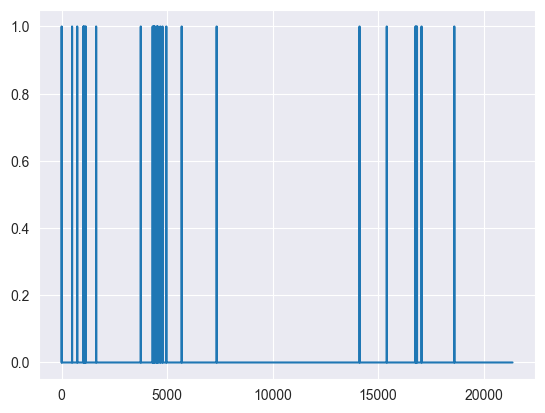

In [8]:
sns.lineplot(target)

In [9]:
feature_arr = dataset[feature_name_list].to_numpy()
dataset_arr = np.concatenate([feature_arr, target.reshape(-1, 1)], axis=1)
print(dataset_arr.shape)

(21374, 7)


In [10]:
n_samples = 2000
max_len = 250

random_start_idx = np.random.randint(low=0, high=dataset_arr.shape[0]-max_len*2, size=n_samples)
random_len_idx = np.random.randint(low=max_len*1, high=max_len*2, size=n_samples)

augment_train_dataset_arr = np.empty(shape=(0, dataset_arr.shape[1]))

for i, j in zip(tqdm(random_start_idx), random_len_idx):
    augment_train_dataset_arr = np.concatenate([augment_train_dataset_arr, dataset_arr[i:i+j, :]], axis=0)

print(augment_train_dataset_arr.shape)
print((augment_train_dataset_arr.itemsize * augment_train_dataset_arr.size)/(1024**2))

  0%|          | 0/2000 [00:00<?, ?it/s]

(744872, 7)
39.78045654296875


In [11]:
# dataset['Work_Load'] = dataset['Work_Load']/4100
# dataset['Work_Load'] = dataset['Work_Load']*100

In [12]:
# feature_name_list = new_angle_name_list + [new_pressure_name_list[0]] + ['Drill_Rotation(RPM)']
# target_name = 'Work_Load'
#
# train_dataset = dataset[dataset['Data_Type']=='train'][feature_name_list+[target_name]]
# train_dataset.reset_index(drop=True, inplace=True)
# train_dataset = train_dataset.to_numpy()
#
# val_dataset = dataset[dataset['Data_Type']=='validation'][feature_name_list+[target_name]]
# val_dataset.reset_index(drop=True, inplace=True)
# val_dataset = val_dataset.to_numpy()
#
# print(train_dataset.shape, val_dataset.shape)

In [13]:
seq_len = 50
pred_distance = 25

train_feature, train_target = create_seq_dataset_multiple_input_single_output(data=augment_train_dataset_arr,
                                                                              seq_len=seq_len,
                                                                              pred_distance=pred_distance,
                                                                              target_idx_pos=augment_train_dataset_arr.shape[1]-1)
train_target = np.squeeze(train_target)
print(train_feature.shape, train_target.shape)

print((train_feature.itemsize*train_feature.size)/(1024**2))
print((train_target.itemsize*train_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/744847 [00:00<?, ?it/s]

(744798, 50, 6) (744798,)
1704.7073364257812
5.6823577880859375


In [14]:
val_feature, val_target = create_seq_dataset_multiple_input_single_output(data=dataset_arr,
                                                                          seq_len=seq_len,
                                                                          pred_distance=pred_distance,
                                                                          target_idx_pos=dataset_arr.shape[1]-1)
val_target = np.squeeze(val_target)
print(val_feature.shape, val_target.shape)

print((val_feature.itemsize*val_feature.size)/(1024**2))
print((val_target.itemsize*val_target.size)/(1024**2))

creating sequence dataset...:   0%|          | 0/21349 [00:00<?, ?it/s]

(21300, 50, 6) (21300,)
48.7518310546875
0.162506103515625


In [15]:
model = build_predict_model(input_shape=(train_feature.shape[1:]), d_dims=64, dropout_rate=0.5, learning_rate=0.001)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 6)]      0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 50, 4)       0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 50, 2)       0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                              

In [16]:
#keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)


In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, verbose=0)
csv_logger = keras.callbacks.CSVLogger(filename=f'log_{pred_distance}_model.csv', append=False, separator=',')
model_chk_point = keras.callbacks.ModelCheckpoint(filepath=f'model_{pred_distance}.keras', monitor="val_loss", verbose=2,
                                                  save_best_only=True, save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(x=train_feature, y=train_target, validation_data=(val_feature, val_target),
          epochs=999999, batch_size=10000, verbose=0, callbacks=[early_stop, csv_logger, model_chk_point, tensorboard_callback])

In [19]:
model = keras.models.load_model(f'model_{pred_distance}.keras', custom_objects={'FeatureWiseScalingLayer': FeatureWiseScalingLayer,
                                                                                'DecompositionLayer': DecompositionLayer})

In [23]:
val_pred = model.predict(val_feature, verbose=1)
val_pred = np.squeeze(val_pred)

666/666 [==============================] - 23s 34ms/step


(0.0, 2000.0)

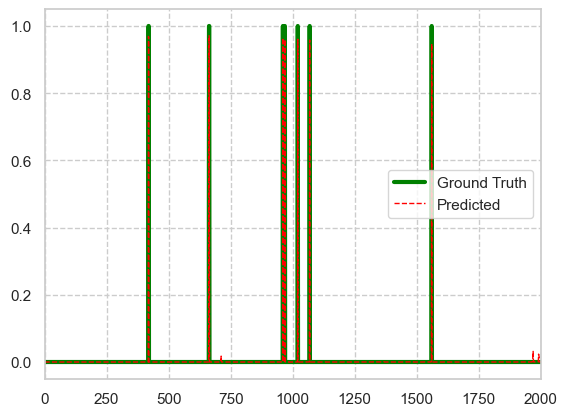

In [30]:
sns.set_theme(font_scale=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.lineplot(val_target, linewidth=3, label='Ground Truth', color='Green')
sns.lineplot(val_pred, linewidth=1, linestyle='--', label='Predicted', color='Red')

plt.xlim(0, 2000)